# INM706 Coursework

- Benjamin Dwumah
- Rachana Shantappa Bhankur



**Run and tested on Google Cloud Platform (GCP)**

## Image Captioning With MS Coco Dataset
In this project, we use ResNet50 and LSTM to design and train a convolutional neural network + recurrent neural network model to automatically generate image captions. The encoder will be CNN, which will extract image features, and the decoder will be RNN, which will model language up to the word level. The network is trained on the MS COCO (Microsoft Common Objects in Context) dataset.

In [1]:
# Import modules
import os
import sys
sys.path.append('/cocoapi/PythonAPI')
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
%matplotlib inline

## Visualize the dataset

To visualize the data, we begin by initializing the COCO API that you will use to obtain the data which is the images and the annotations. Then, we'll plot a random image from the dataset, along with its five corresponding captions. Each time you run the code cell below, a different image is selected.

In the project, we will use this dataset to train our own model to generate captions from images.

In [2]:
# initialize COCO API for instance annotations
datasetDir = './INM706/coco'
datasetType = 'val2017'
instances_annFile = os.path.join(datasetDir, 'annotations/instances_{}.json'.format(datasetType))
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = os.path.join(datasetDir, 'annotations/captions_{}.json'.format(datasetType))
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


http://images.cocodataset.org/val2017/000000453722.jpg


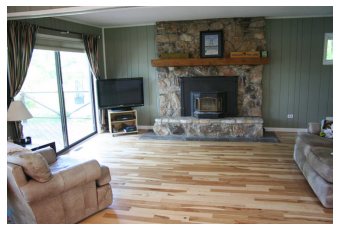

room with wood floors and a stone fire place
Living room area of home with wood flooring and fireplace.
A living room with a fireplace and glass slider doors.
a small roomw ith a televisiona nd some furniture in it 
The chair and couch are in the room with the fireplace.


In [4]:
# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

## Explore Data Loader

We have already written a [data loader](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) that you can use to load the COCO dataset in batches. 

In the code cell below, we will initialize the data loader by using the `get_loader` function in **dataLoader.py**.  


The `get_loader` function takes as input a number of arguments that can be explored in **data_loader.py**. Most of the arguments must be left at their default values, and we are only allowed to amend the values of the arguments below:
1. **`transform`** - an [image transform](http://pytorch.org/docs/master/torchvision/transforms.html) specifying how to pre-process the images and convert them to PyTorch tensors before using them as input to the CNN encoder.  For now, we will keep the transform as provided in `transform_train`.  We will have the opportunity later to choose our own image transform to pre-process the COCO images.
2. **`mode`** - one of `'train'` (loads the training data in batches) or `'test'` (for the test data). We will say that the data loader is in training or test mode, respectively. 
3. **`batch_size`** - determines the batch size.  When training the model, this is number of image-caption pairs used to amend the model weights in each training step.
4. **`vocab_threshold`** - the total number of times that a word must appear in the in the training captions before it is used as part of the vocabulary.  Words that have fewer than `vocab_threshold` occurrences in the training captions are considered unknown words. 
5. **`vocab_from_file`** - a Boolean that decides whether to load the vocabulary from file.  

We will describe the `vocab_threshold` and `vocab_from_file` arguments in more detail soon.

In [5]:
import sys
import nltk
nltk.download('punkt')
from dataLoader import get_loader
from torchvision import transforms
import torch.utils.data as data

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 6

# Specify the batch size.
batch_size = 10

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

loading annotations into memory...
Done (t=0.96s)
creating index...
index created!
[0/591753] Tokenizing captions...
[100000/591753] Tokenizing captions...
[200000/591753] Tokenizing captions...
[300000/591753] Tokenizing captions...
[400000/591753] Tokenizing captions...
[500000/591753] Tokenizing captions...
loading annotations into memory...
Done (t=0.94s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [01:08<00:00, 8611.56it/s]


The data loader was stored in the variable `data_loader`. We can access the corresponding dataset as `data_loader.dataset`.  This dataset is an instance of the `CoCoDataset` class in **data_loader.py**. 

### Exploring the `__getitem__` Method

The `__getitem__` method in the `CoCoDataset` class determines how an image-caption pair is pre-processed before being incorporated into a batch.  This is true for all `Dataset` classes in PyTorch. When the data loader is in training mode, this method begins by first obtaining the filename (`path`) of a training image and its corresponding caption (`caption`).

- Image Pre-Processing: is relatively straightforward (from the `__getitem__` method in the `CoCoDataset` class). The image is converted to a tensor and preprocessed using **`transform`**


- Caption Pre-Processing: The captions also need to be pre-processed and prepped for training. In this notebook, for generating captions, we are aiming to create a model that predicts the next token of a sentence from previous tokens, so we turn the caption associated with any image into a list of tokenized words, before casting it to a PyTorch tensor that we can use to train the network.

In [7]:
# Convert every letter in the caption to lowercase, 
# and the nltk.tokenize.word_tokenize function is used to obtain a list of string-valued tokens. 
sample_caption = 'Three lions standing on a dry grass'
sample_tokens = nltk.tokenize.word_tokenize(str(sample_caption).lower())
print(sample_tokens)

['three', 'lions', 'standing', 'on', 'a', 'dry', 'grass']


We initialize an empty list and append an integer to mark the start of a caption.  The paper [(Oriol et al., 2015)](https://arxiv.org/pdf/1411.4555.pdf) that we took inspiration to implement uses a special start word (and a special end word, which we'll examine below) to mark the beginning and end of a caption.

This special start word (`"<start>"`) is decided when instantiating the data loader and is passed as a parameter (`start_word`).  One is **required** to keep this parameter at its default value (`start_word="<start>"`).

As you will see below, the integer `0` is always used to mark the start of a caption.

In [8]:
# Initialize empty caption list
sample_caption = []

# Append special start word
start_word = data_loader.dataset.vocab.start_word
print('Special start word:', start_word)

# Append integer value of start word
sample_caption.append(data_loader.dataset.vocab(start_word))
print(sample_caption)

Special start word: <start>
[0]


In [9]:
# Add integers that correspond to each of the tokens in the caption.
sample_caption.extend([data_loader.dataset.vocab(token) for token in sample_tokens])
print(sample_caption)

[0, 263, 6108, 330, 49, 3, 2130, 168]


In [10]:
# Append special end word
end_word = data_loader.dataset.vocab.end_word
print('Special end word:', end_word)

# Append integer value of end word
sample_caption.append(data_loader.dataset.vocab(end_word))
print(sample_caption)

Special end word: <end>
[0, 263, 6108, 330, 49, 3, 2130, 168, 1]


In [11]:
# Convert the list of integers to a PyTorch tensor and cast it to long type
sample_caption = torch.Tensor(sample_caption).long()
print(sample_caption)

tensor([   0,  263, 6108,  330,   49,    3, 2130,  168,    1])


In order to convert a token to its corresponding integer, we call `data_loader.dataset.vocab` as a function.  The details of how this call works can be explored in the `__call__` method in the `Vocabulary` class in **vocabulary.py**.  

```python
def __call__(self, word):
    if not word in self.word2idx:
        return self.word2idx[self.unk_word]
    return self.word2idx[word]
```

The `word2idx` instance variable is a Python dictionary that is indexed by string-valued keys (mostly tokens obtained from training captions). For each key, the corresponding value is the integer that the token is mapped to in the pre-processing step.

In [12]:
# Preview the word2idx dictionary.
dict(list(data_loader.dataset.vocab.word2idx.items())[:10])

{'<start>': 0,
 '<end>': 1,
 '<unk>': 2,
 'a': 3,
 'bicycle': 4,
 'replica': 5,
 'with': 6,
 'clock': 7,
 'as': 8,
 'the': 9}

In [13]:
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 9438


As you will see if you examine the code in **vocabulary.py**, the `word2idx` dictionary is created by looping over the captions in the training dataset.  If a token appears no less than `vocab_threshold` times in the training set, then it is added as a key to the dictionary and assigned a corresponding unique integer.  We have the option later to amend the `vocab_threshold` argument when instantiating the data loader.  Note that in general, **smaller** values for `vocab_threshold` yield a **larger** number of tokens in the vocabulary.

In [14]:
# Modify the minimum word count threshold.
vocab_threshold = 6

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!
[0/591753] Tokenizing captions...
[100000/591753] Tokenizing captions...
[200000/591753] Tokenizing captions...
[300000/591753] Tokenizing captions...
[400000/591753] Tokenizing captions...
[500000/591753] Tokenizing captions...
loading annotations into memory...
Done (t=0.94s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [01:09<00:00, 8490.79it/s]


In [15]:
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 9438


There are also a few special keys in the `word2idx` dictionary.  We are already familiar with the special start word (`"<start>"`) and special end word (`"<end>"`).  There is one more special token, corresponding to unknown words (`"<unk>"`).  All tokens that don't appear anywhere in the `word2idx` dictionary are considered unknown words.  In the pre-processing step, any unknown tokens are mapped to the integer `2`.

In [16]:
# Append special unknown word
unk_word = data_loader.dataset.vocab.unk_word
print('Special unknown word:', unk_word)

# Append integer value of unknown word
print('All unknown words are mapped to this integer:', data_loader.dataset.vocab(unk_word))

Special unknown word: <unk>
All unknown words are mapped to this integer: 2


In [17]:
# Test for unknown words in vocabulary
print(data_loader.dataset.vocab('wqedasfs'))
print(data_loader.dataset.vocab('fslsalss'))

2
2


## DataLoader from File

The final thing to mention is the `vocab_from_file` argument that is supplied when creating a data loader.  To understand this argument, note that when you create a new data loader, the vocabulary (`data_loader.dataset.vocab`) is saved as a pickle file in the project folder, with filename `vocab.pkl`.
 

We only need to run the data loader *one more time* with the chosen `vocab_threshold` to save the new vocabulary to file.  Then, we can henceforth set `vocab_from_file=True` to load the vocabulary from file and speed the instantiation of the data loader.  Note that building the vocabulary from scratch is the most time-consuming part of instantiating the data loader, and so we set `vocab_from_file=True`.

Note that if `vocab_from_file=True`, then any supplied argument for `vocab_threshold` when instantiating the data loader is completely ignored.

In [18]:
# Obtain the data loader (from file). Note that it runs much faster than before!
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_from_file=True)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=1.00s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [01:08<00:00, 8652.27it/s]


## Using DataLoader to obtain batches
The captions in the dataset vary greatly in length. One can see this by examining `data_loader.dataset.caption_lengths`, a Python list with one entry for each training caption (where the value stores the length of the corresponding caption).  

In the code cell below, we use this list to print the total number of captions in the training data with each length.  As you will see below, the majority of captions have length 10.  Likewise, very short and very long captions are quite rare.  

In [19]:
from collections import Counter

# Tally the total number of training captions with each length.
counter = Counter(data_loader.dataset.caption_lengths)
lengths = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)
for value, count in lengths:
    print('value: %2d --- count: %5d' % (value, count))

value: 10 --- count: 123316
value: 11 --- count: 114543
value:  9 --- count: 102606
value: 12 --- count: 82271
value: 13 --- count: 53723
value: 14 --- count: 31924
value:  8 --- count: 29696
value: 15 --- count: 18511
value: 16 --- count: 11022
value: 17 --- count:  6928
value: 18 --- count:  4382
value: 19 --- count:  2890
value:  7 --- count:  2297
value: 20 --- count:  2047
value: 21 --- count:  1443
value: 22 --- count:   978
value: 23 --- count:   746
value: 24 --- count:   563
value: 25 --- count:   390
value: 26 --- count:   287
value: 27 --- count:   212
value: 28 --- count:   162
value: 29 --- count:   124
value: 30 --- count:    92
value: 31 --- count:    80
value: 32 --- count:    61
value: 34 --- count:    51
value: 33 --- count:    45
value: 37 --- count:    43
value: 35 --- count:    42
value: 36 --- count:    32
value: 38 --- count:    27
value: 39 --- count:    25
value: 43 --- count:    23
value: 44 --- count:    21
value: 40 --- count:    18
value: 45 --- count:    1

To generate batches of training data, we begin by first sampling a caption length (where the probability that any length is drawn is proportional to the number of captions with that length in the dataset).  Then, we retrieve a batch of size `batch_size` of image-caption pairs, where all captions have the sampled length.  This approach for assembling batches matches the procedure in [Xu et al., 2016](https://arxiv.org/pdf/1502.03044.pdf) and has been shown to be computationally efficient without degrading performance. The `get_train_indices` method in the `CoCoDataset` class first samples a caption length, and then samples `batch_size` indices corresponding to training data points with captions of that length.  These indices are stored below in `indices`.

These indices are supplied to the data loader, which then is used to retrieve the corresponding data points.  The pre-processed images and captions in the batch are stored in `images` and `captions`. Each time you run the code cell above, a different caption length is sampled, and a different batch of training data is returned.

In [20]:
# Randomly sample a caption length, and sample indices with that length.
indices = data_loader.dataset.get_train_indices()
print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler
    
# Obtain the batch.
images, captions = next(iter(data_loader))
    
print('images.shape:', images.shape)
print('captions.shape:', captions.shape)

# (Optional) Uncomment the lines of code below to print the pre-processed images and captions.
print('images:', images)
print('captions:', captions)

sampled indices: [504711, 439255, 388070, 153377, 509197, 298, 272396, 261377, 241383, 476586]
images.shape: torch.Size([10, 3, 224, 224])
captions.shape: torch.Size([10, 11])
images: tensor([[[[ 0.9646,  0.8276,  0.7762,  ..., -2.1008, -2.0665, -2.0494],
          [ 1.0331,  1.0844,  1.1358,  ..., -2.0665, -2.0837, -2.0837],
          [ 0.9303,  0.9817,  1.0673,  ..., -2.0494, -2.0837, -2.0837],
          ...,
          [ 0.1939, -0.2684,  0.1254,  ..., -2.0837, -2.0665, -2.0152],
          [ 0.0398,  0.0227,  0.0227,  ..., -2.1008, -2.0665, -1.9980],
          [ 0.0741,  0.0398,  0.1768,  ..., -2.0837, -2.1008, -2.0323]],

         [[-1.3354, -1.3354, -1.2829,  ..., -1.8782, -1.8782, -1.9132],
          [-1.2654, -1.3704, -1.3529,  ..., -1.9307, -1.9307, -1.9307],
          [-1.5105, -1.5455, -1.4580,  ..., -2.0007, -1.9657, -1.9307],
          ...,
          [-1.5455, -1.6506, -1.5455,  ..., -1.3529, -1.4580, -1.3354],
          [-1.6331, -1.6331, -1.4580,  ..., -1.3704, -1.4755, -1

## Experiment with CNN Encoder

We weill implement a rough patch of the CNN-RNN architecture towards the goal of image captioning before starting the actual training

In [21]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

# Import EncoderCNN and DecoderRNN. 
from model import EncoderCNN, DecoderRNN

In [22]:
# Device for Pytorch Tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

##### Instantiate the CNN encoder in encoder
The pre-processed images from the batch are passed through the encoder, and the output is stored in `features`. The encoder that we used is a pre-trained ResNet-50 architecture (with the final fully-connected layer removed) to extract features from a batch of pre-processed images. The output is then flattened to a vector, before being passed through a `Linear` layer to transform the feature vector to have the same size as the word embedding. We incorporate a pre-trained CNN into the encoder.  The `EncoderCNN` class takes `embed_size` as an input argument, which will also correspond to the dimensionality of the input to the RNN decoder that we will implement later on. 

In [23]:
# Specify the dimensionality of the image embedding.
embed_size = 512

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Initialize the encoder. (Optional: Add additional arguments if necessary.)
encoder = EncoderCNN(embed_size)

# Move the encoder to GPU if CUDA is available.
encoder.to(device)
    
# Move last batch of images to GPU if CUDA is available.   
images = images.to(device)

# Pass the images through the encoder.
features = encoder(images)

print('type(features):', type(features))
print('features.shape:', features.shape)

# Check that the encoder satisfies some requirements of the project! :D
assert type(features)==torch.Tensor, "Encoder output needs to be a PyTorch Tensor." 
assert (features.shape[0]==batch_size) & (features.shape[1]==embed_size), "The shape of the encoder output is incorrect."

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jupyter/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

type(features): <class 'torch.Tensor'>
features.shape: torch.Size([10, 512])


##### Implement the RNN Decoder

The decoder implemented is a copy of  [Oriol et al., 2015](https://arxiv.org/pdf/1411.4555.pdf), which uses at least one RNN layer, with hidden dimension `hidden_size`.

The decoder will be an instance of the `DecoderRNN` class and must accept as input:
- the PyTorch tensor `features` containing the embedded image features (when the last batch of images was passed through `encoder`), along with
- a PyTorch tensor corresponding to the last batch of captions (`captions`).

Note that the way we have written the data loader should simplify the code a bit.  In particular, every training batch will contain pre-processed captions where all have the same length (`captions.shape[1]`), so **we do not need to worry about padding**.

In [24]:
# Specify the number of features in the hidden state of the RNN decoder.
hidden_size = 512

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Store the size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the decoder.
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move the decoder to GPU if CUDA is available.
decoder.to(device)
    
# Move last batch of captions to GPU if CUDA is available 
captions = captions.to(device)

# Pass the encoder output and captions through the decoder.
outputs = decoder(features, captions)

print('type(outputs):', type(outputs))
print('outputs.shape:', outputs.shape)

# Check that the decoder satisfies some requirements of the project! :D
assert type(outputs)==torch.Tensor, "Decoder output needs to be a PyTorch Tensor."
assert (outputs.shape[0]==batch_size) & (outputs.shape[1]==captions.shape[1]) & (outputs.shape[2]==vocab_size), "The shape of the decoder output is incorrect."

type(outputs): <class 'torch.Tensor'>
outputs.shape: torch.Size([10, 11, 9438])


## Training Setup

We will customize the training of our CNN-RNN model by specifying hyperparameters and setting other options that are important to the training procedure.  The values we set now will be used when training our model. 

We begin by setting the following variables:
- `batch_size` - the batch size of each training batch.  It is the number of image-caption pairs used to amend the model weights in each training step. 
- `vocab_threshold` - the minimum word count threshold.  Note that a larger threshold will result in a smaller vocabulary, whereas a smaller threshold will include rarer words and result in a larger vocabulary.  
- `vocab_from_file` - a Boolean that decides whether to load the vocabulary from file. 
- `embed_size` - the dimensionality of the image and word embeddings.  
- `hidden_size` - the number of features in the hidden state of the RNN decoder.  
- `num_epochs` - the number of epochs to train the model.  We recommend `num_epochs=5`. [Xu et al., 2016](https://arxiv.org/pdf/1502.03044.pdf) trained a captioning model on a single state-of-the-art GPU for 3 days, but we'll soon see that you can get reasonable results in a matter of a few hours!  (_But of course, if we want our model to compete with current research, we will have to train for much longer._)
- `save_every` - determines how often to save the model weights.  We recommend `save_every=1`, to save the model weights after each epoch.  This way, after the `i`th epoch, the encoder and decoder weights will be saved in the `models/` folder as `encoder-i.pkl` and `decoder-i.pkl`, respectively.
- `print_every` - determines how often to print the batch loss to the Jupyter notebook while training.  Note that we **will not** observe a monotonic decrease in the loss function while training - this is perfectly fine and completely expected!  We have to keep this at its default value of `100` to avoid clogging the notebook
- `log_file` - the name of the text file containing - for every step - how the loss and perplexity evolved during training.

In [25]:
# Select appropriate values for the Python variables below.
batch_size = 32          # batch size
vocab_threshold = 6        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 5             # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 200          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

In [26]:
import math
# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.bn.parameters())

# Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.96s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [01:09<00:00, 8453.73it/s]


## Train the model

In [ ]:
# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        if time.time() - old_time > 60:
            old_time = time.time()
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
#         print("outputs.shape: ", outputs.shape)
        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./INM706/models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./INM706/models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()

Epoch [1/5], Step [200/18493], Loss: 3.5681, Perplexity: 35.44774
Epoch [1/5], Step [400/18493], Loss: 3.7884, Perplexity: 44.18768
Epoch [1/5], Step [600/18493], Loss: 3.2015, Perplexity: 24.5703
Epoch [1/5], Step [800/18493], Loss: 2.8650, Perplexity: 17.5486
Epoch [1/5], Step [1000/18493], Loss: 3.1376, Perplexity: 23.0484
Epoch [1/5], Step [1200/18493], Loss: 2.6991, Perplexity: 14.8661
Epoch [1/5], Step [1400/18493], Loss: 2.8780, Perplexity: 17.7792
Epoch [1/5], Step [1600/18493], Loss: 2.7411, Perplexity: 15.5042
Epoch [1/5], Step [1800/18493], Loss: 2.6037, Perplexity: 13.5132
Epoch [1/5], Step [2000/18493], Loss: 2.7414, Perplexity: 15.5082
Epoch [1/5], Step [2200/18493], Loss: 2.5198, Perplexity: 12.4266
Epoch [1/5], Step [2400/18493], Loss: 3.0138, Perplexity: 20.36485
Epoch [1/5], Step [2600/18493], Loss: 3.0944, Perplexity: 22.0747
Epoch [1/5], Step [2800/18493], Loss: 2.5887, Perplexity: 13.3122
Epoch [1/5], Step [3000/18493], Loss: 2.4454, Perplexity: 11.5354
Epoch [1/5]

In [33]:
!tar chvfz notebook.tar.gz INM/models

INM/models/
INM/models/decoder-5.pkl
INM/models/decoder-3.pkl
INM/models/decoder-1.pkl
INM/models/encoder-3.pkl
INM/models/decoder-2.pkl
INM/models/encoder-1.pkl
INM/models/encoder-4.pkl
INM/models/encoder-2.pkl
INM/models/decoder-4.pkl
INM/models/encoder-5.pkl
